In [2]:
import numpy as np
import pathlib
import glob
import pandas as pd
import matplotlib.pyplot as plt
import PIL

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import roc_auc_score, confusion_matrix
from collections import Counter

In [3]:
# Band meanings
bandMeanings = {
    0: "Coastal Aerosol",
    1: "Blue",
    2: "Green",
    3: "Red",
    4: "Vegetation Red Edge 1",
    5: "Vegetation Red Edge 2",
    6: "Vegetation Red Edge 3",
    7: "Near-Infrared",
    8: "Narrow Near-Infrared",
    9: "Water Vapor",
    10: "Cirrus",
    11: "Shortwave Infrared 1",
    12: "Shortwave Infrared 2"
}
bandMeanings

{0: 'Coastal Aerosol',
 1: 'Blue',
 2: 'Green',
 3: 'Red',
 4: 'Vegetation Red Edge 1',
 5: 'Vegetation Red Edge 2',
 6: 'Vegetation Red Edge 3',
 7: 'Near-Infrared',
 8: 'Narrow Near-Infrared',
 9: 'Water Vapor',
 10: 'Cirrus',
 11: 'Shortwave Infrared 1',
 12: 'Shortwave Infrared 2'}

In [4]:
# Lets build a pattern vector , n by m, where n=total number of pixels and m=13, form the L1C data
# Simultaneously read the snow GT from the L2A data


base_path = '../data_murray/'
l1c_glob_string = base_path + r'**/l1c/**/*.npy'
l2a_glob_string = base_path + r'**/l2a/**/*.npy'
print(l1c_glob_string)

l1c_list = sorted(list(glob.glob(l1c_glob_string, recursive=True)))
l2a_list = sorted(list(glob.glob(l2a_glob_string, recursive=True)))
print(len(l1c_list), len(l2a_list))
# assert len(l1c_list) == len(l2a_list)

../data_murray/**/l1c/**/*.npy
2230 2128


In [8]:
def find_corresponding_gt(p1, p2_list):
# Find the file l2a (ie GT) in flist which corresponds to the filename f which is a l1c file
    assert p1.find('/l1c/') > 0
    af = p1.replace('/l1c/', '/l2a/').replace('_MSIL1C_', '_MSIL2A_' )
    keystr = af[15:81]
    
    matches = [p for p in p2_list if p.find(keystr) > 0]
    assert len(matches) <= 1   # Problem if multiple matches
    if matches == []:
        return None
    else:
        return matches[0]
    
def test_find_corresponding_gt():
    p1 = "../data_murray/An_Riabhachan/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_20180913T114351_N0206_R123_T30VUJ_20180913T135232.SAFE.npy"
    p2 = find_corresponding_gt(p1, l2a_list)
    assert len(p1) == len(p2)
    print(p1)
    print(p2)
    diff = ''.join([c2 if c1 != c2 else '-' for c1, c2 in zip(p1, p2)])
    print(diff)
test_find_corresponding_gt()
    

../data_murray/An_Riabhachan/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_20180913T114351_N0206_R123_T30VUJ_20180913T135232.SAFE.npy
../data_murray/An_Riabhachan/l2a/2018-05-01-2018-09-30/S2A_MSIL2A_20180913T114351_N0208_R123_T30VUJ_20180913T144400.SAFE.npy
------------------------------2a-------------------------------2A---------------------8-----------------------44400---------


In [29]:

def build_feats_and_gt_lists(max_cloud_cover_pc=50, only_every=10):
    # Return a tuple of corresponding lists:
    # 1: list of file paths of l1c (13 band) data
    # 2: list dataframes, each with one row per-pixel, columns for features (13) + 3 GT related columns
    path_list = []
    df_list = []
    for p1 in l1c_list[0::only_every]:
        p2 = find_corresponding_gt(p1, l2a_list)
        if p2 is None:
            print(f"No GT for {p1[:70]}, skipping")
            continue
        # print(p1, p2)
        imStack = np.load(p1)
        nx, ny, nb = imStack.shape
        assert nb == 13

        featsOneIm = imStack.reshape(nx * ny, nb)
        df = pd.DataFrame(featsOneIm, columns=bandMeanings.values())

        # Load the image from where we'll get GT
        gtIm = np.load(p2)
        assert gtIm.shape[0:1] == imStack.shape[0:1]
        df['SCL'] = gtIm[:,:,0].flatten()  # Value of 11 is snow
        df['SnowProb'] = gtIm[:,:,1].flatten()   
        df['CloudProb'] = gtIm[:,:,2].flatten()

        if df['CloudProb'].mean() > max_cloud_cover_pc:
            print(f"Rejecting, {p1[:70]}...")
            continue
        path_list += [p1]
        df_list += [df]
    return path_list, df_list

def test_build_feats_and_gt_lists():
    path_list, df_list = build_feats_and_gt_lists(max_cloud_cover_pc=80, only_every=200)
    print(f"\nFound {len(path_list)} patches.  Following is just one")
    print(path_list[0])
    print(df_list[0].describe())
test_build_feats_and_gt_lists()

Rejecting, ../data_murray/An_Riabhachan/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_2018...
No GT for ../data_murray/An_Stuc/l1c/2019-05-01-2019-09-30/S2B_MSIL1C_20190506T1, skipping
Rejecting, ../data_murray/Beinn_a_Bhuird/l1c/2020-05-01-2020-09-30/S2B_MSIL1C_202...
Rejecting, ../data_murray/Carn_na_Caim/l1c/2022-05-01-2022-09-30/S2A_MSIL1C_20220...
Rejecting, ../data_murray/Ciste_Mhearad/l1c/2020-05-01-2020-09-30/S2B_MSIL1C_2020...
No GT for ../data_murray/Coire_Cruach_Sneachda/l1c/2020-05-01-2020-09-30/S2B_MSI, skipping

Found 6 patches.  Following is just one
../data_murray/An_Riabhachan/l1c/2021-05-01-2021-09-30/S2A_MSIL1C_20210719T114351_N0500_R123_T30VUJ_20230123T031427.SAFE.npy
       Coastal Aerosol          Blue         Green           Red  \
count     22630.000000  22630.000000  22630.000000  22630.000000   
mean       3568.691825   3349.195625   3141.525541   3211.357976   
std        1063.231112   1217.034462   1240.447725   1444.485607   
min        1833.000000   1354.000000   1

### Meanings of SCL codes

0 - No data
1 - Saturated / Defective
2 - Dark Area Pixels
3 - Cloud Shadows
4 - Vegetation
5 - Bare Soils
6 - Water
7 - Clouds low probability / Unclassified
8 - Clouds medium probability
9 - Clouds high probability
10 - Cirrus
11 - Snow / Ice

Rejecting, ../data_murray/An_Riabhachan/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_2018...
Rejecting, ../data_murray/An_Riabhachan/l1c/2021-05-01-2021-09-30/S2A_MSIL1C_2021...
Rejecting, ../data_murray/An_Riabhachan/l1c/2022-05-01-2022-09-30/S2B_MSIL1C_2022...
No GT for ../data_murray/An_Stuc/l1c/2019-05-01-2019-09-30/S2B_MSIL1C_20190506T1, skipping
Rejecting, ../data_murray/An_Stuc/l1c/2021-05-01-2021-09-30/S2A_MSIL1C_20210619T1...
Rejecting, ../data_murray/Aonach_Beag/l1c/2019-05-01-2019-09-30/S2A_MSIL1C_201909...
Rejecting, ../data_murray/Beinn_a_Bhuird/l1c/2019-05-01-2019-09-30/S2A_MSIL1C_201...
Rejecting, ../data_murray/Beinn_a_Bhuird/l1c/2020-05-01-2020-09-30/S2B_MSIL1C_202...
Rejecting, ../data_murray/Beinn_a_Bhuird/l1c/2022-05-01-2022-09-30/S2B_MSIL1C_202...
Rejecting, ../data_murray/Carn_na_Caim/l1c/2020-05-01-2020-09-30/S2B_MSIL1C_20200...
Rejecting, ../data_murray/Carn_na_Caim/l1c/2022-05-01-2022-09-30/S2A_MSIL1C_20220...
Rejecting, ../data_murray/Ciste_Mhearad/l1c/2020-05-01-2020

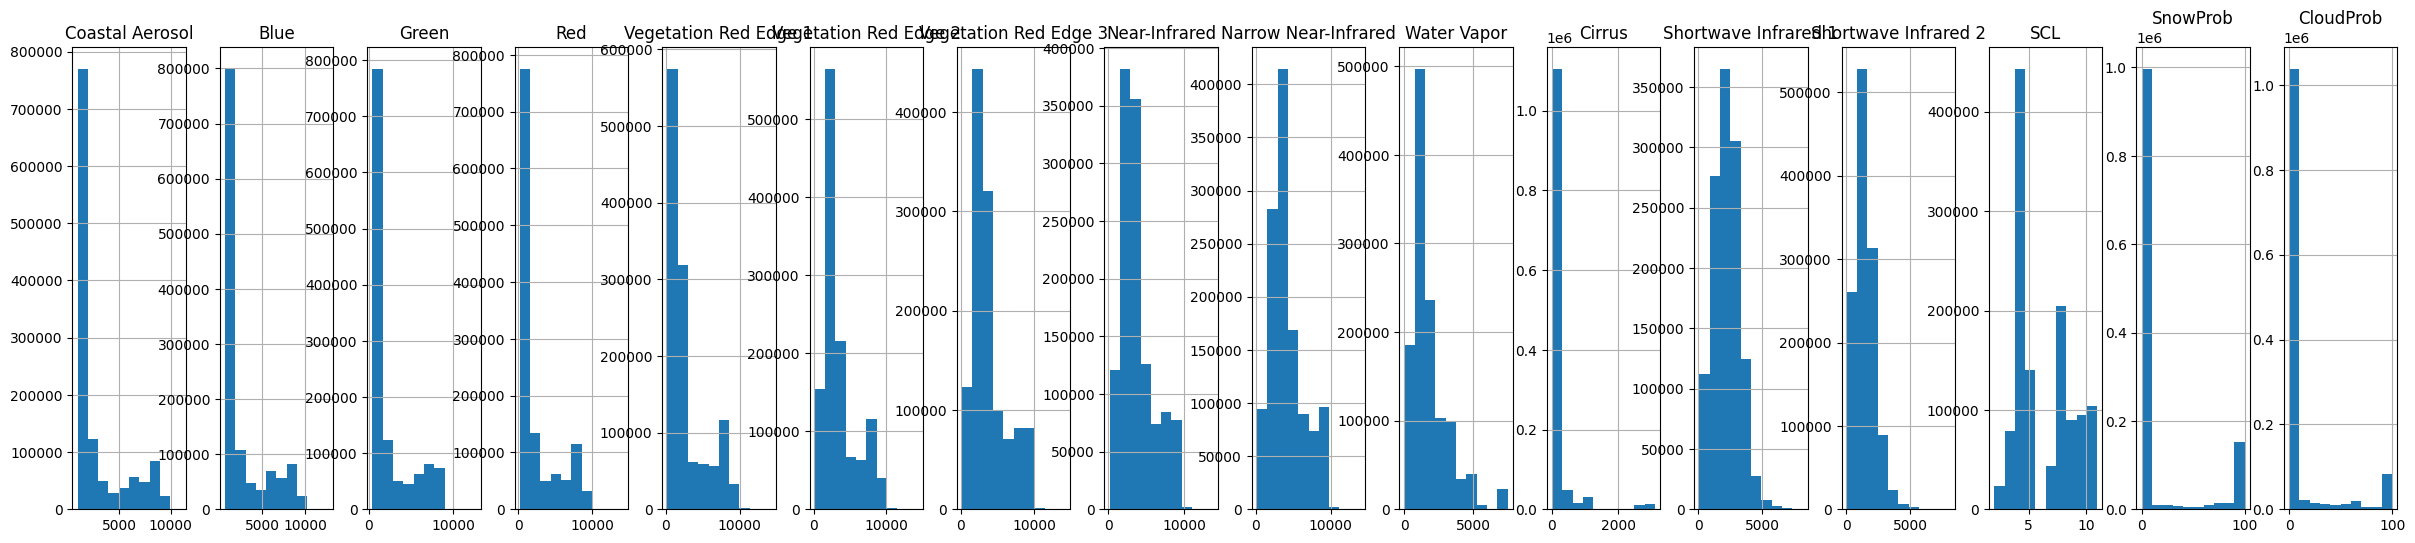

In [43]:
def build_total_df_and_gt(df_list):
    # Return a tuple:
    # X_df: a concatonated dataframe containing band information only, and 
    # y: a concatenated GT array
    # Thus X_df, y are ready to be fed to sklearn
    
    df_list_feats_only = [df.iloc[:, :13] for df in df_list]
    gt_list = [np.array(df['SCL']) for df in df_list]
    
    X_df = np.concatenate(df_list_feats_only)
    y = np.hstack(gt_list)
    y = (y==11)   # 11 is "Snow"
    return X_df, y
    
def test_build_total_df_and_gt():
    path_list, df_list = build_feats_and_gt_lists(max_cloud_cover_pc=50, only_every=100)
    X_df, y = build_total_df_and_gt(df_list)
    print(f"Total #pixels: {len(X_df)}, class counts: {Counter(y)}")
    fig, axis = plt.subplots(1, 16, figsize=(30,6))
    total_df.hist(ax=axis)
    plt.show()
    assert len(X_df) == len(y)
    
test_build_total_df_and_gt()
    


## Lets do some SkLearning...

In [55]:
path_list, df_list = build_feats_and_gt_lists(max_cloud_cover_pc=20, only_every=10)
X_df, y = build_total_df_and_gt(df_list)

X_train, X_test, y_train, y_test = train_test_split(X_df, y, stratify=y)
y_test = np.array(y_test)
y_train = np.array(y_train)
print(X_train.shape)

Rejecting, ../data_murray/An_Riabhachan/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_2018...
Rejecting, ../data_murray/An_Riabhachan/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_2018...
Rejecting, ../data_murray/An_Riabhachan/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_2018...
Rejecting, ../data_murray/An_Riabhachan/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_2018...
Rejecting, ../data_murray/An_Riabhachan/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_2018...
Rejecting, ../data_murray/An_Riabhachan/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_2018...
Rejecting, ../data_murray/An_Riabhachan/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_2018...
Rejecting, ../data_murray/An_Riabhachan/l1c/2019-05-01-2019-09-30/S2A_MSIL1C_2019...
Rejecting, ../data_murray/An_Riabhachan/l1c/2019-05-01-2019-09-30/S2A_MSIL1C_2019...
Rejecting, ../data_murray/An_Riabhachan/l1c/2019-05-01-2019-09-30/S2A_MSIL1C_2019...
Rejecting, ../data_murray/An_Riabhachan/l1c/2019-05-01-2019-09-30/S2B_MSIL1C_2019...
Rejecting, ../data_murray/An_Riabhachan/l1c/2019-05-01-2019-09-30

Rejecting, ../data_murray/Beinn_a_Bhuird/l1c/2020-05-01-2020-09-30/S2B_MSIL1C_202...
Rejecting, ../data_murray/Beinn_a_Bhuird/l1c/2020-05-01-2020-09-30/S2B_MSIL1C_202...
Rejecting, ../data_murray/Beinn_a_Bhuird/l1c/2020-05-01-2020-09-30/S2B_MSIL1C_202...
Rejecting, ../data_murray/Beinn_a_Bhuird/l1c/2021-05-01-2021-09-30/S2A_MSIL1C_202...
Rejecting, ../data_murray/Beinn_a_Bhuird/l1c/2021-05-01-2021-09-30/S2B_MSIL1C_202...
Rejecting, ../data_murray/Beinn_a_Bhuird/l1c/2021-05-01-2021-09-30/S2B_MSIL1C_202...
Rejecting, ../data_murray/Beinn_a_Bhuird/l1c/2021-05-01-2021-09-30/S2B_MSIL1C_202...
Rejecting, ../data_murray/Beinn_a_Bhuird/l1c/2022-05-01-2022-09-30/S2A_MSIL1C_202...
Rejecting, ../data_murray/Beinn_a_Bhuird/l1c/2022-05-01-2022-09-30/S2A_MSIL1C_202...
Rejecting, ../data_murray/Beinn_a_Bhuird/l1c/2022-05-01-2022-09-30/S2B_MSIL1C_202...
Rejecting, ../data_murray/Beinn_a_Bhuird/l1c/2022-05-01-2022-09-30/S2B_MSIL1C_202...
Rejecting, ../data_murray/Beinn_a_Bhuird/l1c/2022-05-01-2022-09-3

In [56]:
# Setup a sklearn Pipeline
pipe = Pipeline([
    ("Scaling", StandardScaler()),
    ("Classifier", QuadraticDiscriminantAnalysis())
])

cls = pipe.fit(X_train, y_train)
cls.score(X_test, y_test)

0.9793594980781495

In [57]:
roc_auc_score(y_test, cls.predict_proba(X_test)[:,1])

0.9857066729560373

In [58]:
confusion_matrix(y_test, cls.predict(X_test))

array([[208809,   4166],
       [   624,  18469]])

In [59]:
im = PIL.Image.fromarray(np.ones((10,23), np.uint8))

im.save('gash.png') 

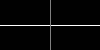

In [60]:
def array_to_png(a):
    assert np.min(a) >=0 and np.max(a) <= 255
    im = PIL.Image.fromarray(a.astype(np.uint8))
    return im
def test_array_to_png():
    a = np.ones((50,100))
    a[25,:]=255
    a[:,50]=128
    im = array_to_png(a)
    return im
test_array_to_png()

../data_murray/An_Riabhachan/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_20180503T113321_N0206_R080_T30VUJ_20180503T151930.SAFE.npy


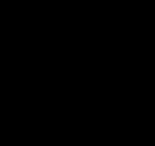

../data_murray/An_Riabhachan/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_20180506T114351_N0206_R123_T30VUJ_20180506T120844.SAFE.npy


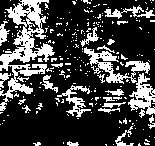

../data_murray/An_Riabhachan/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_20180513T113321_N0206_R080_T30VUJ_20180513T133943.SAFE.npy


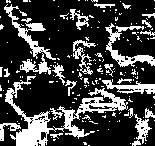

../data_murray/An_Riabhachan/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_20180516T114351_N0206_R123_T30VUJ_20180516T120702.SAFE.npy


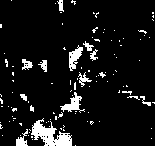

../data_murray/An_Riabhachan/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_20180523T113321_N0206_R080_T30VUJ_20180523T165348.SAFE.npy


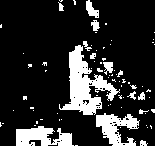

../data_murray/An_Riabhachan/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_20180526T114351_N0206_R123_T30VUJ_20180526T170241.SAFE.npy


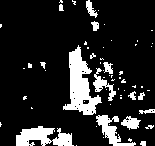

../data_murray/An_Riabhachan/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_20180602T113321_N0206_R080_T30VUJ_20180602T135138.SAFE.npy


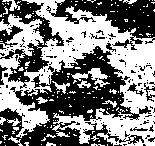

../data_murray/An_Riabhachan/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_20180605T114351_N0206_R123_T30VUJ_20180605T115603.SAFE.npy


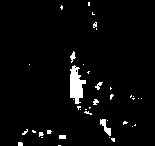

../data_murray/An_Riabhachan/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_20180612T113321_N0206_R080_T30VUJ_20180612T133308.SAFE.npy


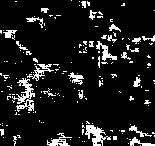

../data_murray/An_Riabhachan/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_20180615T114351_N0206_R123_T30VUJ_20180615T120927.SAFE.npy


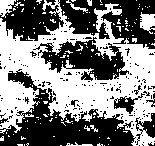

../data_murray/An_Riabhachan/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_20180622T113321_N0206_R080_T30VUJ_20180622T115330.SAFE.npy


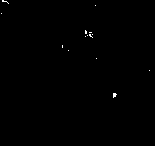

../data_murray/An_Riabhachan/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_20180625T114351_N0206_R123_T30VUJ_20180625T170237.SAFE.npy


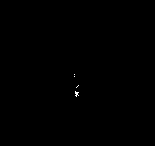

../data_murray/An_Riabhachan/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_20180702T113321_N0206_R080_T30VUJ_20180702T132802.SAFE.npy


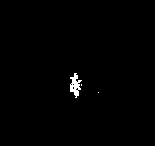

../data_murray/An_Riabhachan/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_20180705T114351_N0206_R123_T30VUJ_20180705T134119.SAFE.npy


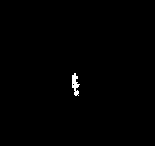

../data_murray/An_Riabhachan/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_20180712T113321_N0206_R080_T30VUJ_20180712T133430.SAFE.npy


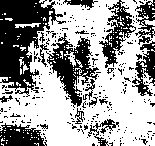

../data_murray/An_Riabhachan/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_20180715T114351_N0206_R123_T30VUJ_20180715T134723.SAFE.npy


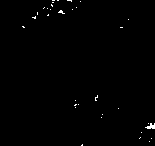

../data_murray/An_Riabhachan/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_20180722T113321_N0206_R080_T30VUJ_20180722T133135.SAFE.npy


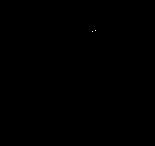

../data_murray/An_Riabhachan/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_20180725T114351_N0206_R123_T30VUJ_20180725T134458.SAFE.npy


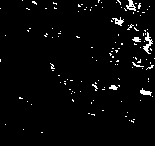

../data_murray/An_Riabhachan/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_20180801T113321_N0206_R080_T30VUJ_20180801T170415.SAFE.npy


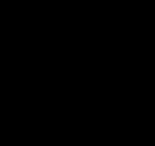

../data_murray/An_Riabhachan/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_20180804T114351_N0206_R123_T30VUJ_20180804T135526.SAFE.npy


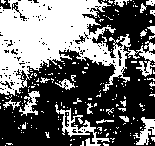

../data_murray/An_Riabhachan/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_20180811T113321_N0206_R080_T30VUJ_20180811T133749.SAFE.npy


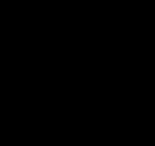

../data_murray/An_Riabhachan/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_20180814T114351_N0206_R123_T30VUJ_20180816T173726.SAFE.npy


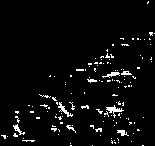

../data_murray/An_Riabhachan/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_20180821T113321_N0206_R080_T30VUJ_20180821T115344.SAFE.npy


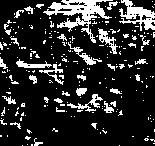

../data_murray/An_Riabhachan/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_20180824T114351_N0206_R123_T30VUJ_20180824T143902.SAFE.npy


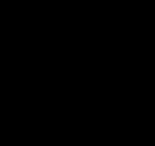

../data_murray/An_Riabhachan/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_20180831T113321_N0206_R080_T30VUJ_20180831T134402.SAFE.npy


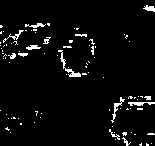

../data_murray/An_Riabhachan/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_20180903T114351_N0206_R123_T30VUJ_20180903T135210.SAFE.npy


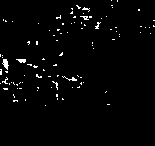

../data_murray/An_Riabhachan/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_20180910T113321_N0206_R080_T30VUJ_20180910T152016.SAFE.npy


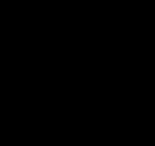

../data_murray/An_Riabhachan/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_20180913T114351_N0206_R123_T30VUJ_20180913T135232.SAFE.npy


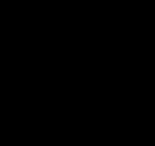

../data_murray/An_Riabhachan/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_20180920T113311_N0206_R080_T30VUJ_20180920T115427.SAFE.npy


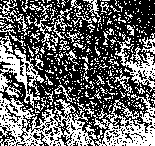

../data_murray/An_Riabhachan/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_20180923T114341_N0206_R123_T30VUJ_20180923T135012.SAFE.npy


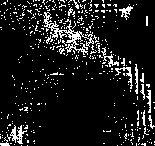

../data_murray/An_Riabhachan/l1c/2018-05-01-2018-09-30/S2A_MSIL1C_20180930T113321_N0206_R080_T30VUJ_20180930T134150.SAFE.npy


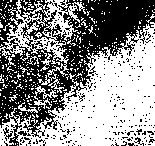

../data_murray/An_Riabhachan/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_20180501T114349_N0206_R123_T30VUJ_20180501T152629.SAFE.npy


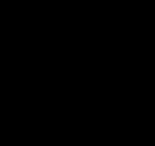

../data_murray/An_Riabhachan/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_20180508T113319_N0206_R080_T30VUJ_20180508T150628.SAFE.npy


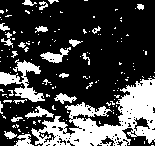

../data_murray/An_Riabhachan/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_20180511T114349_N0206_R123_T30VUJ_20180511T151544.SAFE.npy


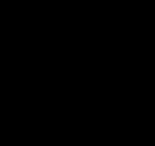

../data_murray/An_Riabhachan/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_20180518T113319_N0206_R080_T30VUJ_20180518T133554.SAFE.npy


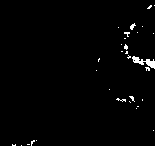

../data_murray/An_Riabhachan/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_20180521T114349_N0206_R123_T30VUJ_20180521T134522.SAFE.npy


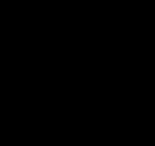

../data_murray/An_Riabhachan/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_20180528T113319_N0206_R080_T30VUJ_20180528T115853.SAFE.npy


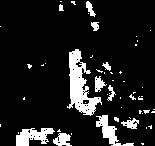

../data_murray/An_Riabhachan/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_20180531T114349_N0206_R123_T30VUJ_20180531T134218.SAFE.npy


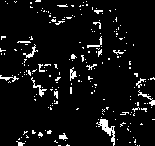

../data_murray/An_Riabhachan/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_20180607T113319_N0206_R080_T30VUJ_20180607T134041.SAFE.npy


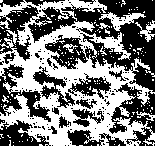

../data_murray/An_Riabhachan/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_20180610T114349_N0206_R123_T30VUJ_20180610T134000.SAFE.npy


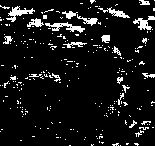

../data_murray/An_Riabhachan/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_20180617T113319_N0206_R080_T30VUJ_20180617T123104.SAFE.npy


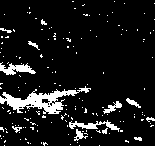

../data_murray/An_Riabhachan/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_20180620T114349_N0206_R123_T30VUJ_20180620T184330.SAFE.npy


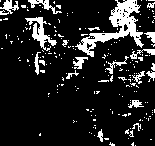

../data_murray/An_Riabhachan/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_20180627T113319_N0206_R080_T30VUJ_20180627T132817.SAFE.npy


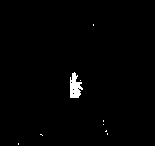

../data_murray/An_Riabhachan/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_20180630T114349_N0206_R123_T30VUJ_20180630T165917.SAFE.npy


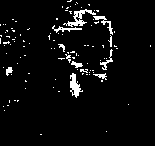

../data_murray/An_Riabhachan/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_20180707T113319_N0206_R080_T30VUJ_20180707T151546.SAFE.npy


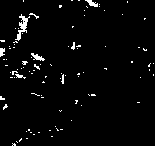

../data_murray/An_Riabhachan/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_20180710T114349_N0206_R123_T30VUJ_20180710T165949.SAFE.npy


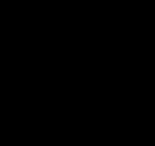

../data_murray/An_Riabhachan/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_20180717T113319_N0206_R080_T30VUJ_20180717T150756.SAFE.npy


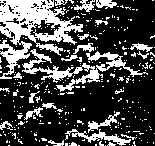

../data_murray/An_Riabhachan/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_20180720T114349_N0206_R123_T30VUJ_20180720T165939.SAFE.npy


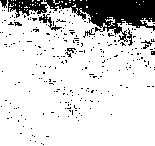

../data_murray/An_Riabhachan/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_20180727T113319_N0206_R080_T30VUJ_20180727T152212.SAFE.npy


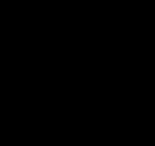

../data_murray/An_Riabhachan/l1c/2018-05-01-2018-09-30/S2B_MSIL1C_20180730T114349_N0206_R123_T30VUJ_20180730T185913.SAFE.npy


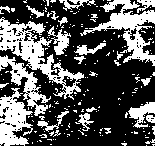

In [61]:
# Classify images and display as .png
for p in l1c_list[:50]:
    print(p)
    imStack = np.load(p)
    nx, ny, nb = imStack.shape
    assert nb == 13
    
    featsOneIm = imStack.reshape(nx * ny, nb)
    
    classified_image = cls.predict(featsOneIm)
    classified_image = classified_image.reshape(nx, ny) * 255
    im = array_to_png(classified_image)
    display(im)
    